# Data Science Case Study
## Bank Direct Marketing: Clients' term deposit subscription prediction.

_Author: Fred Bone_

---

**Domain Background**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**problem statement**

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

**Datasets and Inputs**

The data is public available and has been taken from the open source datasets repository **UCI Machine Learning Repository**: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science and comes from the **paper**: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014.

Input variables:
###### bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
###### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
###### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
###### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)
###### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')


In [75]:
# Import libraries

# To handle datasets
import pandas as pd
import numpy as np
import scipy.stats as ss

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# To split the datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Feature engineering 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# To build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from numpy import argmax

# To evaluate the models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To persist the model and the scaler
import joblib
import pickle

# To visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# To ignore the warnings
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

##  I - Data Analysis

In [2]:
# load dataset
data = pd.read_csv('datasets/bank.csv', sep=';')

# Rows and columns of the data
print(data.shape)

# Visualise the dataset
data.head(10)

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


The data contains 4521 rows (observations) and 17 columns (variables). The last column (y) is the one that we will try to predict. We will analyse the dataset to identify:

1. Identify numerical / categorical variables
2. Missing values
3. Is the data set balanced or unbalanced?
4. Outliers
5. Potential variables that could be dropped by checking the correlation matrix

### 1. Identify numerical / categorical variables

In [3]:
# make list of numerical variables
num_vars = [var for var in data.columns if data[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))
print(num_vars)

Number of numerical variables:  7
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [4]:
# Capture categorical variables in a list
cat_vars = [var for var in data.columns[:-1] if data[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))
print(cat_vars)

Number of categorical variables:  9
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


### 2. Missing values

In [5]:
# List of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

print("Number of variables with missing values: {0}".format(len(vars_with_na)))
# Descending percentage of missing values (in case of any)
if len(vars_with_na) < 0:
    print("Descending percentage of missing values:")
    data[vars_with_na].isnull().mean().sort_values(ascending=False)

Number of variables with missing values: 0


### 3. Is the data set balanced or unbalanced?

In [67]:
data['y'].value_counts() / len(data['y'])

no     0.88476
yes    0.11524
Name: y, dtype: float64

The data set is unbalanced with the class no having more records than the one yes.We will use metrics that are appropriate to evaluate models on unbalanced data sets (F1 score, Precision, Recall). Additionally, while splitting the data in the train/test set, we will make sure that the train set reflects the same proportion of data we had in each class (so-called stratified sample).

### 4. Outliers

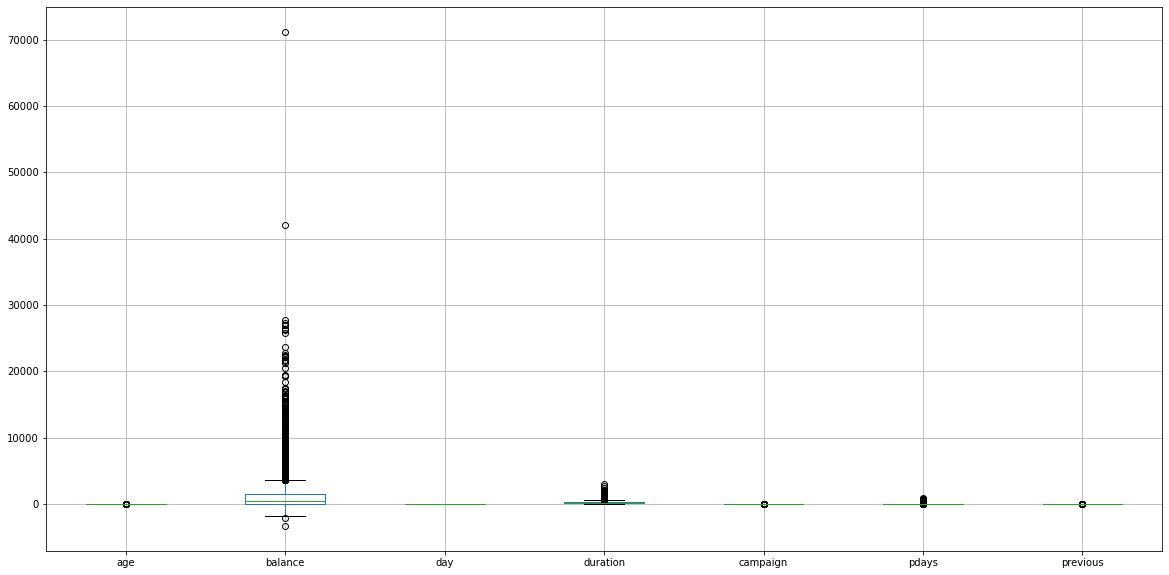

In [7]:
# outliers
data[num_vars].boxplot(figsize=(20,10))

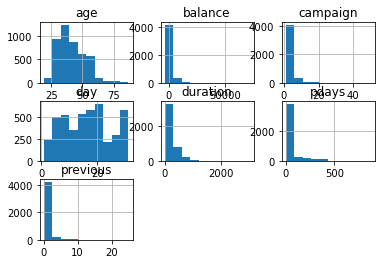

In [8]:
# Histograms of the numerical variables
data[num_vars].hist()
plt.show()

### 5. Potential variables that could be dropped by checking the correlation matrix

### 5.1. Pearson correlation between numerical variables

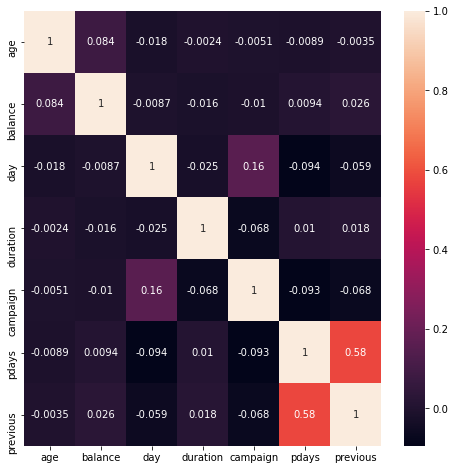

In [61]:
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, annot=True)

The greatest positive value resp. the smallest negative value between two different variables is 0.58 resp. -0.09. Hence there's no significant correlation between the numerical variables and thus no need to remove any of them. 

### 5.2. Cramer's V correaltion between categorical variables

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [63]:
cramer_corr = []
for i in range(len(cat_vars)):
    for j in range(len(cat_vars)):
        cramer_corr.append(cramers_v(data[cat_vars[i]], data[cat_vars[j]])) 
cramer_corr = np.array(cramer_corr).reshape(len(cat_vars), len(cat_vars))
cramer_corr = pd.DataFrame(cramer_corr, columns=cat_vars, index=cat_vars)

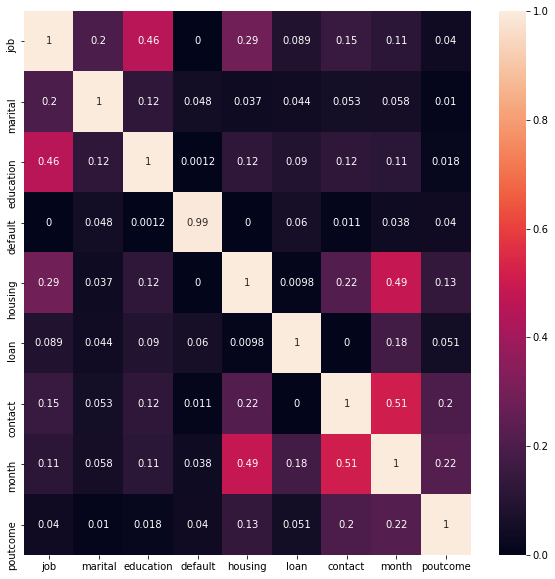

In [62]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cramer_corr, annot=True)

The greatest positive value between two different variables is 0.51. Hence there's no significant correlation between the categorical variables and thus no need to remove any of them. 

## II- Separate the data into train and test set

In [71]:
# Label encode the target variable
le = LabelEncoder()
data['le_y'] = le.fit_transform(data['y'])

# Persist label encoder
np.save('classes.npy', le.classes_)
# le = LabelEncoder()
# le.classes_ = numpy.load('classes.npy')

list(le.classes_)


['no', 'yes']

In [72]:
# Check if we can reverse a random verctor of prediction
le.inverse_transform([0, 1, 1])

array(['no', 'yes', 'yes'], dtype=object)

In [107]:
# Separate into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['y', 'le_y'], axis=1),  # just the features
    data['le_y'],  # the target
    test_size=0.3,  # the percentage of observations in the test set
    random_state=101, # for reproducibility
   stratify=data['le_y'])  # To create datasets featuring the same percentage of classes as the original one

X_train.shape, X_test.shape

((3164, 16), (1357, 16))

Checking if the training set is stratified

In [108]:
print("Percentage of classes in the original data:")
print(data['y'].value_counts() / len(data['y']))
print("")
print("Percentage of classes in the training set:")
print(y_train.value_counts() / len(y_train))

Percentage of classes in the original data:
no     0.88476
yes    0.11524
Name: y, dtype: float64

Percentage of classes in the training set:
0    0.88464
1    0.11536
Name: le_y, dtype: float64


In [116]:
# Preprocessing pipeline for the numerical variables

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_vars),
        ('categorical', categorical_transformer, cat_vars)])


In [117]:
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']), ('categorical', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_featur...)]), ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])],
         verbose=False)

In [118]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.fit_transform(X_test)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
clf_lr = LogisticRegression(random_state=101)
clf_lr.fit(X_train_prep, y_train)

,job,marital,education,default,housing,loan,contact,month,poutcome
0,unemployed,married,primary,no,no,no,cellular,oct,unknown
1,services,married,secondary,no,yes,yes,cellular,may,failure
2,management,single,tertiary,no,yes,no,cellular,apr,failure
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
4516,services,married,secondary,no,yes,no,cellular,jul,unknown
4517,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown
4518,technician,married,secondary,no,no,no,cellular,aug,unknown
4519,blue-collar,married,secondary,no,no,no,cellular,feb,other


In [84]:
# Create the parameter grid 
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [500, 1500, 2000],
    'criterion': ['entropy'],
    'random_state': [101] # for reproductivity
}
# Create a based model
clf_rf = RandomForestClassifier(criterion = 'entropy', random_state=101)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = clf_rf, param_grid = param_grid_rf, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [85]:
# Fit the grid search to the data
grid_search_rf.fit(X_train_prep, y_train)
grid_search_rf.best_params_

NameError: name 'X_train_prep' is not defined